# Machine Learning

## Árvore de Decisão Interativa

In [ ]:
# Carregando biblotecas

from ipywidgets import interactive
from IPython.display import SVG, display
from graphviz import Source
import os

In [ ]:
# Carregando bibliotecas

import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

In [ ]:
# Gerando a árvore

data = load_iris()                    # load dataset
X = data.data                         # feature matrix
y = data.target                       # target vector
features_label = data.feature_names   # feature labels
class_label = data.target_names       # class label


def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = tree.DecisionTreeClassifier(
           random_state = 0 
          ,criterion = crit
          ,splitter = split
          ,max_depth = depth
          ,min_samples_split=min_split
          ,min_samples_leaf=min_leaf
    )

    estimator.fit(X, y)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=features_label
      , class_names=class_label
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4,5]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

**Navegando na estrutura da árvore**

In [ ]:
# Carregando e dividindo os dados

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# Instânciando e treinando o modelo

estimator = tree.DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

In [ ]:
# Dados da árvore

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

In [ ]:
# Imprimindo os dados da árvore

print("Número de nós: {}".format(n_nodes))
print("Indices a esquerda: {}".format(children_left))
print("Indices a direita: {}".format(children_right))
print("Feature: {}".format(feature))
print("Limite (threshold: {}".format(threshold))

Número de nós: 5
Indices a esquerda: [ 1 -1  3 -1 -1]
Indices a direita: [ 2 -1  4 -1 -1]
Feature: [ 3 -2  2 -2 -2]
Limite (threshold: [ 0.80000001 -2.          4.95000005 -2.         -2.        ]


In [ ]:
# Descrição da árvore

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("\nA arvore binária tem %s nós e a seguinte estrutura: \n"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snó=%s (nó folha)." % (node_depth[i] * "\t", i))
    else:
        print("%snó=%s (nó teste): vai para o nó %s se o valor do atributo %s <= %s \n se não, vai para o "
              "nó %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 iris.feature_names[feature[i]],
                 threshold[i],
                 children_right[i],
                 ))


A arvore binária tem 5 nós e a seguinte estrutura: 

nó=0 (nó teste): vai para o nó 1 se o valor do atributo petal width (cm) <= 0.800000011920929 
 se não, vai para o nó 2.
	nó=1 (nó folha).
	nó=2 (nó teste): vai para o nó 3 se o valor do atributo petal length (cm) <= 4.950000047683716 
 se não, vai para o nó 4.
		nó=3 (nó folha).
		nó=4 (nó folha).


**Extraindo dados da árvore**

In [ ]:
# Criando uma função para extração dos dados

def extrai_regras(sample_id):
    node_indicator = estimator.decision_path(X_test)

    leave_id = estimator.apply(X_test)

    #sample_id = sample
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('\nRegras usadas para predizer a amostra %s' % (sample_id))

    for f,v in zip(iris.feature_names,X_test[sample_id]):
        print('%s = %s'%(f,v))

    print('\n')      
    for node_id in node_index:
        if leave_id[sample_id] == node_id:
            continue

        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("id do nó de decisão %s : (atributo %s com valor = %s %s %s)"
              % (node_id,
                 iris.feature_names[node_id],
                 X_test[sample_id, feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))
    pred =estimator.predict(X_test[sample_id].reshape(1, -1)) 
    print("\tClasse => %s" %iris.target_names[pred])

In [ ]:
# Extraindo dados

extrai_regras(2)


Regras usadas para predizer a amostra 2
sepal length (cm) = 5.5
sepal width (cm) = 4.2
petal length (cm) = 1.4
petal width (cm) = 0.2


id do nó de decisão 0 : (atributo sepal length (cm) com valor = 0.2 <= 0.800000011920929)
	Classe => ['setosa']


**Visualizando fronteiras da árvore**

In [ ]:
# Carregando bibliotecas

from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

In [ ]:
# Criando uma função

def visualize_fronteiras(msamples_split):
    X = iris.data[:, [0, 2]]
    y = iris.target

    clf = tree.DecisionTreeClassifier(min_samples_split=msamples_split)
    arvore = clf.fit(X, y)

    plt.figure(figsize=(8,5))
    plot_decision_regions(X, y, clf=arvore, legend=2)

    plt.xlabel('sepal length [cm]')
    plt.ylabel('petal length [cm]')
    plt.title('Decision Tree on Iris')
    plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


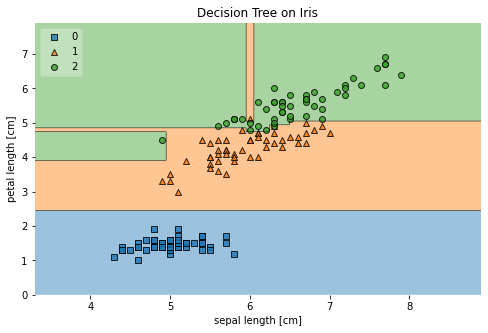

In [ ]:
# Visualizando as fronteiras
visualize_fronteiras(2)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


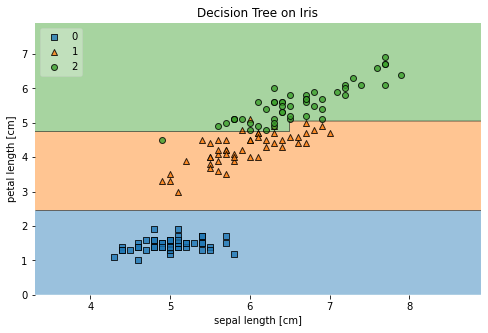

In [ ]:
# Visualizando fronteiras
visualize_fronteiras(10);